In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import pearsonr
from tabulate import tabulate  
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [26]:
df_capabilities = pd.read_csv("dane\\ANational Material Capabilities\\NMC-60-abridged.csv")
df_system = pd.read_csv("dane\\AStates\\system2016.csv")
df_states = pd.read_csv("dane\\AStates\\states2016.csv")
df_inter_wars =pd.read_csv("dane\\AWars\\Inter-StateWarData_v4.0.csv")
df_majors  = pd.read_csv("dane\\AStates\\majors2016.csv")

In [27]:

# Filtrowanie głównych mocarstw w ramach ich lat obowiązywania
filtered_df = df_capabilities.merge(df_majors, left_on='stateabb', right_on='stateabb')
filtered_df = filtered_df[(filtered_df['year'] >= filtered_df['styear']) & (filtered_df['year'] <= filtered_df['endyear'])]

# Grupowanie danych po latach
grouped = filtered_df.groupby('year')

# Obliczanie udziałów i średnich dla każdego roku
results = []
for rok, group in grouped:
    total_capabilities = group.iloc[:, 3:9].sum()  # Sumujemy zdolności dla danego roku
    udzialy = group.iloc[:, 3:9].div(total_capabilities, axis=1)   # Udziały procentowe
    udzialy['stateabb'] = group['stateabb']
    udzialy['year'] = rok
    udzialy['cinc'] = udzialy.iloc[:, :-2].mean(axis=1)  # Średnia arytmetyczna
    results.append(udzialy[[ 'year', 'stateabb','cinc']])

# Łączenie wyników w jeden DataFrame
cincs = pd.concat(results)
cincs.head(10)

,year,stateabb,cinc
201,1816,UKG,0.428162
402,1816,FRN,0.167278
802,1816,GMY,0.070947
1273,1816,AUH,0.105513
1577,1816,RUS,0.228100
202,1817,UKG,0.413393
404,1817,FRN,0.161417
805,1817,GMY,0.070707
1274,1817,AUH,0.134263
1579,1817,RUS,0.220220


1.	Pierwszy krok to obliczenie wskaźników wojny CON, $\Delta $ CON, MOVE dla okresu 1820–1965. Wskaźniki są obliczane dla każdego $t = t_1-t_0 = \{1, 5 ,10\}$. 

# CON


$$CON_{t_0} = \sqrt{\cfrac{\sum^{N_{t_0}} S^2_{it_0} - \dfrac{1}{N_{t_0}}}{1 - \dfrac{1}{N_{t_0}}}}$$

gdzie $S_{it_0}$ (czasem oznaczane jako $ P_{it_0}$) to ranga państwa, czyli procentowy udział państwa w systemie (system rozumiany jako wszystkie państwa) w czasie $t_0$, a $N_{t_0}$ to liczba GŁÓWNYCH MOCARSTW w systemie w czasie $t_0$.

CON to wskaźnik pokazujący koncentrację mocy w systemie, tj. czy moc jest skoncentrowana w małej ilości państw, czy rozłożona równomiernie pomiędzy państwami. 

# $\Delta$ CON

$$\Delta CON_{t_0 \to t_1} = \dfrac{CON_{t_1} - CON_{t_0}}{t_1 - t_0}$$
$\Delta$ CON wskazuje stopień, w jakim koncentracja mocy wzrosła lub spadła w okresie $t_0 - t_1$.

# MOVE

$$MOVE_{t_0 \to t_1} = \dfrac{\sum^{N_t}|S_{it_1} - S_{it_0}|}{2(1 - S_{mt})}$$

gdzie $S_{mt}$ to państwo z najmniejszą rangą w czasie $t_0 - t_1$.

# WAR

$$WAR_{t_1 \to t_2} = \dfrac{1}{t_2 - t_1}\sum_{w} \sum_{p}  m_{w,p}$$

gdzie $w$ liczba wojen w okresie $t_1$ - $t_2$, 

$p$ liczba państw w wojnie, 

$m_{w,p}$ liczba miesięcy udziału państwa $p$ w wojnie $w$

> A typical set of observations would be: ΔCON and MOVE from 1 January 1840 to1 January 1845; CON at 1 January 1840; and WAR from 1 January 1845 through 31 December 1849

In [34]:
def indicators(start_year, end_year, t, model, df_capabilities, df_inter_wars):
    """
    model:  1 - CON liczony na początku okresu t; 
            2 - CON liczony na końcu okresu t

    """
    
    years = np.arange(start_year, end_year + 1, 1)
    n = len(years)
    k = np.arange(0, n, t)
    
    years_wars = np.arange(start_year, end_year + t + 1, 1)
    n_wars = len(years_wars)
    k_wars = np.arange(t, n_wars, t)
    
    if t == 5:
        # Definiujemy mapę „podmian” lat:
        overrides = {
            1915: 1913,
            1940: 1938,
            1945: 1946
        }
        # Podmieniamy indeksy w k (czyli główny przedział do liczenia DCON i MOVE):
        for i in range(len(k)):
            original_year = years[k[i]]
            if original_year in overrides:
                new_year = overrides[original_year]
                # Szukamy indeksu w `years` odpowiadającego naszemu new_year
                new_idx = np.where(years == new_year)[0]
                if len(new_idx) > 0:
                    k[i] = new_idx[0]

        # Podmieniamy indeksy w k_wars (przedziały do liczenia WAR):
        for i in range(len(k_wars)):
            original_year_war = years_wars[k_wars[i]]
            if original_year_war in overrides:
                new_year_war = overrides[original_year_war]
                new_idx_war = np.where(years_wars == new_year_war)[0]
                if len(new_idx_war) > 0:
                    k_wars[i] = new_idx_war[0]    
    
    CON = np.zeros(n)
    DCON = np.zeros(len(k) - 1)
    MOVE = np.zeros(len(k) - 1)
    WAR = np.zeros(len(k_wars) - 1)
    
    df_year = df_capabilities.groupby('year')#
    year_groups = {year: group for year, group in df_year}#

    # CON
    for j, year in enumerate(years):
        if year in year_groups:
            group = year_groups[year]
            majors_in_year = df_majors[
            (df_majors['styear'] <= year) & (df_majors['endyear'] >= year)
            ]            
            major_cincs = group[group['ccode'].isin(majors_in_year['ccode'])]['cinc'].values
            N = len(major_cincs)
            summ = np.sum(major_cincs**2)
            CON[j] = np.sqrt(np.abs((summ - 1 / N) / (1 - 1 / N)))
            
    # DCON
    for i in range(len(k) - 1):
        if t == 1:
            DCON[i] = (CON[k[i+1]] - CON[k[i]])
        else:
            DCON[i] = (CON[k[i + 1]-1] - CON[k[i]]) /t
    
    #MOVE
    for j in range(len(k) - 1):
        
        
        if t == 1:
            start_year, end_year = years[k[j]], years[k[j + 1]]
        else:
            start_year, end_year = years[k[j]], years[k[j + 1]-1]
            
        major_states_in_period = df_majors[
        (df_majors['styear'] <= end_year) &
        (df_majors['endyear'] >= start_year)
        ]['stateabb'].unique()

        capabilities_in_t = df_capabilities[
            (df_capabilities['year'] >= start_year) &
            (df_capabilities['year'] <= end_year) &
            (df_capabilities['stateabb'].isin(major_states_in_period))]
        capabilities_by_state = capabilities_in_t.groupby('stateabb')
        
        Smin = capabilities_in_t['cinc'].min()
        summ = 0
        
        for state, group in capabilities_by_state:
            start_cinc = group[group['year'] == start_year]['cinc']
            end_cinc = group[group['year'] == end_year]['cinc']
            if not start_cinc.empty and not end_cinc.empty:
                summ += abs(end_cinc.values[0] - start_cinc.values[0])
        
        MOVE[j] = summ / (2 * t*(1 - Smin)) if Smin < 1 else 0

    # WAR
    for y in range(len(k_wars) - 1):
        start, end = years_wars[k_wars[y]], years_wars[k_wars[y + 1] - 1]

        wars_in_period = df_inter_wars[
            ((df_inter_wars['StartYear1'] <= end) & (df_inter_wars['EndYear1'] >= start)) |
            ((df_inter_wars['StartYear1'] >= start) & (df_inter_wars['EndYear1'] <= end))
        ]

        participant_months = 0

        for _, war in wars_in_period.iterrows():
            
            war_start_year = max(start, war['StartYear1'])
            war_end_year = min(end, war['EndYear1'])

            war_start_month = war['StartMonth1'] if war['StartMonth1'] > 0 else 1
            war_end_month = war['EndMonth1'] if war['EndMonth1'] > 0 else 12

            
            if war_start_year == start:
                war_start_month = max(war_start_month, 1)
            if war_end_year == end:
                war_end_month = min(war_end_month, 12)

            if (war_end_year > war_start_year) or (war_end_year == war_start_year and war_end_month >= war_start_month):
                
                months_in_war = (war_end_year - war_start_year) * 12 + (war_end_month - war_start_month + 1)

                participant_months += months_in_war 

        # Рассчитываем среднегодовое значение
        WAR[y] = participant_months / t

   
    if model == 1:
        data  = {'WAR': WAR, 
                 'CON': CON[k][:-1],
                 'DCON': DCON, 
                 'MOVE': MOVE}  
        df = pd.DataFrame(data, index=years_wars[k_wars][:-1]) 
        return df
    else:
        if t == 1:
            data  = {'WAR': WAR, 
                 'CON': CON[k[1:]],
                 'DCON': DCON, 
                 'MOVE': MOVE}  
            df = pd.DataFrame(data, index=years_wars[k_wars][:-1]) 
            return df
        else:
            data  = {'WAR': WAR, 
                 'CON': CON[k-1][1:],
                 'DCON': DCON, 
                 'MOVE': MOVE}  
            df = pd.DataFrame(data, index=years_wars[k_wars][:-1]) #index znaczy że w tym roku+t był tyle woin, ale index nie odnosi się do pozostałych współczynników
            return df

indicators(1820, 1890, 5, 2, df_capabilities, df_inter_wars)

,WAR,CON,DCON,MOVE
1825,7.2,0.204542,-0.007706,0.004484
1830,0.0,0.224016,0.003112,0.001248
1835,0.0,0.261199,0.000339,0.001926
1840,0.0,0.271591,0.001492,0.003173
1845,16.6,0.268133,0.001841,0.002308
1850,6.0,0.278788,0.005163,0.005423
1855,15.6,0.233935,-0.008477,0.004741
1860,14.2,0.302505,0.006028,0.007309
1865,44.2,0.320743,0.009815,0.009312
1870,6.4,0.300384,-0.000122,0.004620


In [30]:
def descriptive_statistics(Years, T, models, df_capabilities, df_inter_wars):
    markdown_sections = []
    
    for t in T:

        table_rows = []

        headers = [
            "Period", "Indicator", "Expected value", "VAR",
            "Standard deviation", "Median", "Skewness", "Kurtosis"
        ]

        for years in Years:
            for model in models: 

                df = indicators(years[0], years[1], t, model, df_capabilities, df_inter_wars)

                Indicators = ['WAR', "CON", "DCON", "MOVE"]
                for ind in Indicators:
                    if ind == 'CON':
                        indicator_label = f"{ind} (Model {model})"
                    else:
                        indicator_label = ind
                    
                    mean = df[ind].mean()
                    var = df[ind].var()
                    maxx = df[ind].max()
                    minn = df[ind].min()
                    std_dev = df[ind].std()
                    median = df[ind].median()
                    skewness = df[ind].skew()
                    kurtosis = df[ind].kurtosis()

                    row = [
                        f"{years[0]} - {years[1]}",
                        indicator_label,
                        f"{mean:.4f}",
                        f"{var:.4f}",
                        f"{std_dev:.4f}",
                        f"{maxx:.4f}",
                        f"{minn:.4f}",
                        f"{median:.4f}",
                        f"{skewness:.4f}",
                        f"{kurtosis:.4f}"
                    ]

                    table_rows.append(row)

        table = tabulate(table_rows, headers=headers, tablefmt="pipe")

        markdown_sections.append(f"Wyniki dla t = {t}\n\n{table}\n")

    return "\n".join(markdown_sections)

Years = [[1820,1960], [1820,1890], [1890,1960]]
T = [1,5,10]
models = [2]#,2]

final_table = descriptive_statistics(Years, T, models, df_capabilities, df_inter_wars)

print(final_table)

Wyniki dla t = 1

|             |               |   Period |   Indicator |   Expected value |     VAR |   Standard deviation |   Median |   Skewness |   Kurtosis |
|:------------|:--------------|---------:|------------:|-----------------:|--------:|---------------------:|---------:|-----------:|-----------:|
| 1820 - 1960 | WAR           |   8.6214 |    210.05   |          14.4931 | 71      |               0      |   0      |     2.1154 |     4.2456 |
| 1820 - 1960 | CON (Model 2) |   0.26   |      0.0053 |           0.0727 |  0.4335 |               0.0394 |   0.2722 |    -0.6865 |     0.5053 |
| 1820 - 1960 | DCON          |   0.0009 |      0.0017 |           0.0416 |  0.2231 |              -0.1434 |   0.0017 |     1.0144 |    10.6564 |
| 1820 - 1960 | MOVE          |   0.0211 |      0.0003 |           0.0186 |  0.133  |               0.003  |   0.0149 |     2.6987 |    10.5432 |
| 1820 - 1890 | WAR           |   5.1286 |     89.6499 |           9.4684 | 35      |               0     

## 2. Korelacja pomiędzy wskażnikami a wojną


In [31]:
def correlation(Years, t, model, df_capabilities, df_inter_wars):
    
    table_rows = []  
    headers = ["Indicator"] + [f"{years[0]}-{years[1]}" for years in Years]  
    
    for ind in ["CON", "DCON", "MOVE"]:  
        row = [ind]  
        for years in Years:  
            df = indicators(years[0], years[1], t, model, df_capabilities, df_inter_wars)
            r = df['WAR'].corr(df[ind])
            r_squared = r ** 2
            row.append(f"R = {r:.2f}, R² = {r_squared:.2f}")
        
        table_rows.append(row)

    table = tabulate(table_rows, headers=headers, tablefmt="pipe", stralign="center")
    return f't = {t}, Model: {model} \n{table}'

T = [5]#1, 5, 10]

for i in T:

    result = correlation(
        Years=[[1820, 1960], [1820, 1890], [1890, 1960]],
        t = i,
        model = 2,
        df_capabilities=df_capabilities,
        df_inter_wars=df_inter_wars
    )

    print( result)



t = 5, Model: 2 
|  Indicator  |      1820-1960       |      1820-1890      |      1890-1960       |
|:-----------:|:--------------------:|:-------------------:|:--------------------:|
|     CON     | R = -0.02, R² = 0.00 | R = 0.26, R² = 0.07 | R = 0.04, R² = 0.00  |
|    DCON     | R = 0.19, R² = 0.04  | R = 0.29, R² = 0.09 | R = 0.24, R² = 0.06  |
|    MOVE     | R = 0.08, R² = 0.01  | R = 0.54, R² = 0.29 | R = -0.09, R² = 0.01 |


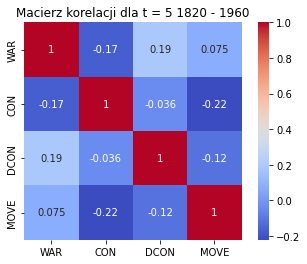

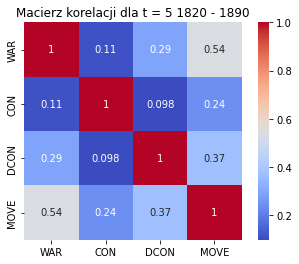

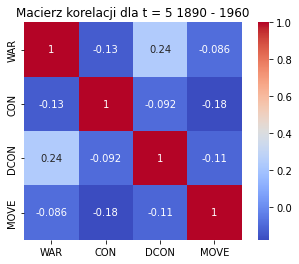

In [32]:
Years = [[1820, 1960], [1820,1890], [1890, 1960]]
T=[5]#1,2,5,10]
model = 1

for t in T:
    for years in Years:
        df = indicators(years[0], years[1], t, model, df_capabilities, df_inter_wars)
        correlation_matrix = df[['WAR', 'CON', 'DCON', 'MOVE']].corr()

        # Wizualizacja
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
        plt.title(f"Macierz korelacji dla t = {t} {years[0]} - {years[1]}")
        plt.savefig(f'wykresy\\plot{t}_{years[0]}_{years[1]}')
        plt.show()
        results = df.describe()
        len(results), results[1:2]

# 3. Badania czterech modeli.

Pierwszy model:
$$WAR_{t_1 \to t_2} = \alpha + \beta_1 CON_{t_0} + \beta_2\Delta CON_{t_0 \to t_1} + \beta_3 MOVE_{t_0 \to t_1} + \epsilon\quad (1)$$

Autor proponuje dwa podejścia:
addytywne (jak powyżej) oraz multiplikatywne:
$$WAR_{t_1 \to t_2} = \alpha \cdot \beta_1^{CON_{t_0}} \cdot \beta_2^{\Delta CON_{t_0 \to t_1}} \cdot \beta_3^{MOVE_{t_0 \to t_1}} \cdot \epsilon\quad (3)$$

Każde z podejść dzieli się na dwa warianty: wskaźnik koncentracji mocy (CON) liczony w czasie $t_0$ (jak powyżej) oraz wskaźnik liczony w czasie $t_1$:
$$WAR_{t_1 \to t_2} = \alpha + \beta_1 CON_{t_1} + \beta_2\Delta CON_{t_0 \to t_1} + \beta_3 MOVE_{t_0 \to t_1} + \epsilon\quad (2)$$
$$WAR_{t_1 \to t_2} = \alpha \cdot \beta_1^{CON_{t_1}} \cdot \beta_2^{\Delta CON_{t_0 \to t_1}} \cdot \beta_3^{MOVE_{t_0 \to t_1}} \cdot \epsilon \quad (4)$$

$$\Downarrow$$

$$\ln{(WAR_{t_1 \to t_2})} = \ln{(\alpha)} + \ln{(\beta_1)} CON_{t_1} + \ln{(\beta_2)}\Delta CON_{t_0 \to t_1} + \ln{(\beta_3)} MOVE_{t_0 \to t_1} + \ln{(\epsilon)}$$

In [33]:
def transform_war(war_values):
    W = np.zeros(len(war_values))
    for i in  range (len(war_values)):
        if war_values[i] == 0:
            W[i] = 0
        else:
            W[i] = np.log(war_values[i])
            
    return W

def model_(start_year, end_year, t, model_type, df_capabilities, df_inter_wars):
    
    """
    model:  1 - model addytywny, CON na początku okresu t
            2 - model addytywny, CON na końcu okresu t
            3 - model multiplikatywny, CON na początku okresu t
            4 - model multiplikatywny, CON na końcu okresu t
    """
    
    if model_type == 1 or model_type == 3: 
        df = indicators(start_year, end_year, t, 1, df_capabilities, df_inter_wars) 
        if model_type == 3:
            df['log_WAR'] = transform_war(df['WAR'])
            X = df[['CON', 'DCON', 'MOVE']]
            y = df['log_WAR']
        else:
            X = df[['CON', 'DCON', 'MOVE']]
            y = df['WAR']
    elif model_type == 2 or model_type == 4:
        df = indicators(start_year, end_year, t, 2, df_capabilities, df_inter_wars)   
        if model_type == 4:
            df['log_WAR'] = transform_war(df['WAR'])

            X = df[['CON', 'DCON', 'MOVE']]
            y = df['log_WAR']
        else:
            X = df[['CON', 'DCON', 'MOVE']]
            y = df['WAR']
            
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
        
    return model

Years = [[1820, 1960], [1820,1890], [1890,1960]]
T=[5]
models = [1,2,3,4]

for t in T:
    for years in Years:
        for model in models:
            print(f'model: {model}, {years[0]} - {years[1]}, t = {t}')
            Model = model_(years[0], years[1], t, model, df_capabilities, df_inter_wars)
            print(Model.summary())

model: 1, 1820 - 1960, t = 5
                            OLS Regression Results                            
Dep. Variable:                    WAR   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                 -0.049
Method:                 Least Squares   F-statistic:                    0.5760
Date:                Tue, 07 Jan 2025   Prob (F-statistic):              0.636
Time:                        02:44:24   Log-Likelihood:                -146.16
No. Observations:                  28   AIC:                             300.3
Df Residuals:                      24   BIC:                             305.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.8905  

KeyError: 0

Reszty nie mają rozkładu normalnego.


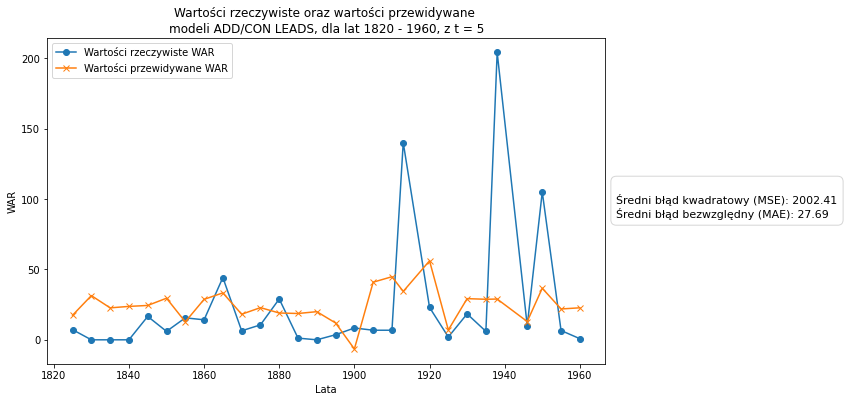

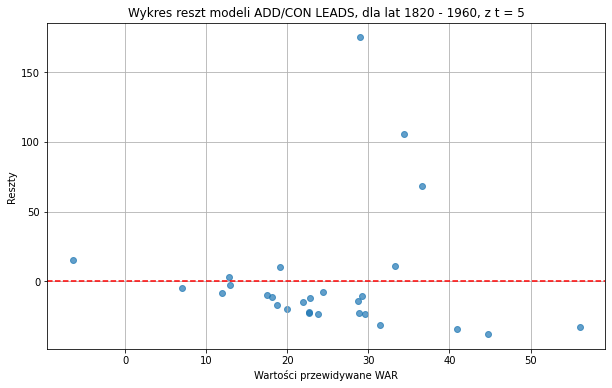

Reszty nie mają rozkładu normalnego.


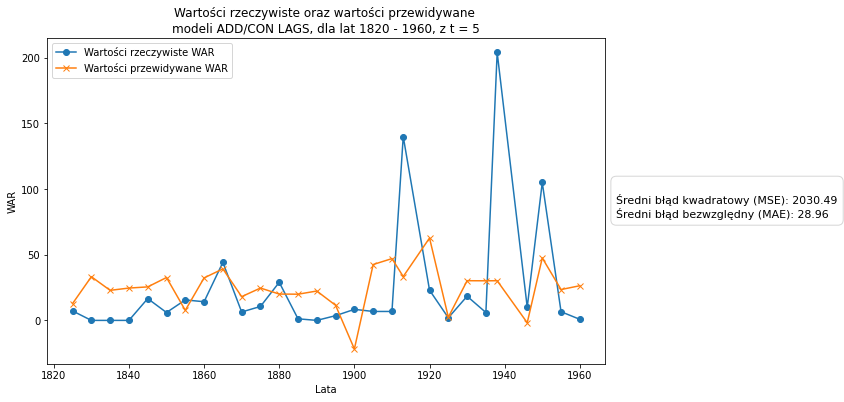

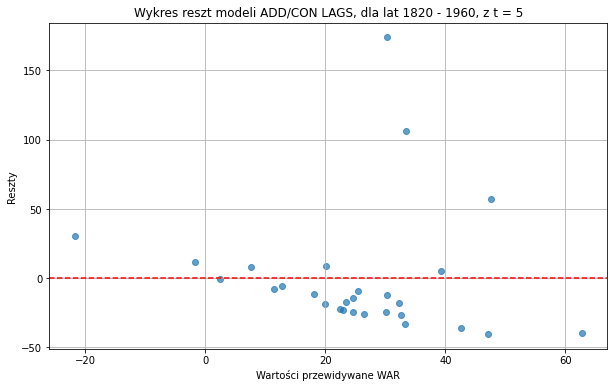

KeyError: 0

In [24]:
Years = [[1820, 1960], [1820,1890], [1890, 1960]]
T=[5]
names = ['ADD/CON LEADS', "ADD/CON LAGS", "MULT/CON LEADS", "MULT/CON LAGS"]
models = [1,2,3,4]

for t in T:
    for years in Years:
        for model, name in zip(models, names):
            if name == 'ADD/CON LEADS' or name == 'ADD/CON LAGS':
                df_test = indicators(years[0],years[1],t,1,df_capabilities, df_inter_wars)
            else: 
                df_test = indicators(years[0],years[1],t,2,df_capabilities, df_inter_wars)
            df_test_X = sm.add_constant(df_test[['CON', 'DCON', 'MOVE']])

            Model = model_(years[0],years[1],t,model, df_capabilities, df_inter_wars)
            predictions = Model.predict(df_test_X)
            
            if name == 'MULT/CON LEADS' or name == 'MULT/CON LAGS':
                predictions = np.exp(predictions)
            
            mae = mean_absolute_error(df_test['WAR'], predictions)
            mse = mean_squared_error(df_test['WAR'], predictions)         
            plt.figure(figsize=(10, 6))
            plt.plot(df_test['WAR'], label='Wartości rzeczywiste WAR', marker='o')
            plt.plot(predictions, label='Wartości przewidywane WAR', marker='x')
            plt.title(f'Wartości rzeczywiste oraz wartości przewidywane \nmodeli {name}, dla lat {years[0]} - {years[1]}, z t = {t}')
            plt.xlabel('Lata')
            plt.ylabel('WAR')
            plt.legend()

            # Dodanie MSE i MAE pod legendą
            bbox_props = dict(facecolor='white', edgecolor='lightgray', alpha=0.9, boxstyle='round,pad=0.5')
            mse_mae_text = f'\nŚredni błąd kwadratowy (MSE): {mse:.2f}\nŚredni błąd bezwzględny (MAE): {mae:.2f}'
            plt.gca().text(1.02, 0.5, mse_mae_text, transform=plt.gca().transAxes, fontsize=11, bbox=bbox_props, verticalalignment='center')
            
            residuals = df_test['WAR'] - predictions
            stat, p = shapiro(residuals)
            
            if p > 0.05: print("Reszty mają rozkład normalny.") 
            else: print("Reszty nie mają rozkładu normalnego.")
            
            # Drugi wykres: wykres reszt
            plt.figure(figsize=(10, 6))
            plt.scatter(predictions, residuals, alpha=0.7)
            plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
            plt.title(f'Wykres reszt modeli {name}, dla lat {years[0]} - {years[1]}, z t = {t}')
            plt.xlabel('Wartości przewidywane WAR')
            plt.ylabel('Reszty')
            plt.grid()
            plt.show()
                        
            

            

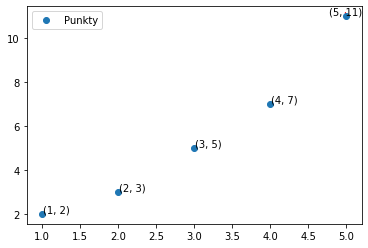

In [12]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Dane
x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]

plt.plot(x, y, 'o', label='Punkty')

# Dodanie tekstów do punktów
texts = [plt.text(xi, yi, f'({xi}, {yi})') for xi, yi in zip(x, y)]

# Automatyczne rozmieszczenie tekstów
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.legend()
plt.show()


# Ewaluacja modelu (niedokończone)

In [ ]:

df = indicators(1820, 1960, 5, 1, df_capabilities, df_inter_wars) 
X = df[['CON', 'DCON', 'MOVE']]
y = df['WAR']

X_standardized = (X - X.mean()) / X.std()
y_standardized = (y - y.mean()) / y.std()

model = LinearRegression()
model.fit(X_standardized, y_standardized)

y_pred = model.predict(X_standardized)


# R (Multiple correlation coefficient)
R = np.sqrt(r2_score(y_standardized, y_pred))
print("R (Multiple correlation coefficient):", R)

# R^2 (Coefficient of multiple determination)
R_squared = r2_score(y_standardized, y_pred)
print("R^2 (Coefficient of multiple determination):", R_squared)

# Corrected R^2 (Adjusted R^2)
n = X.shape[0]  # number of observations
p = X.shape[1]  # number of predictors
adjusted_R_squared = 1 - ((1 - R_squared) * (n - 1) / (n - p - 1))
print("Corrected R^2 (Adjusted R^2):", adjusted_R_squared)

# Standardized regression coefficients (beta coefficients)
beta_coefficients = model.coef_
print("Standardized regression coefficients:", beta_coefficients)

# Squared partial correlation coefficients (r^2)
partial_r_squared = []
for i in range(X_standardized.shape[1]):

    x = X_standardized.iloc[:, i]

    X_others = X_standardized.drop(X_standardized.columns[i], axis=1)

    model_x = sm.OLS(x, sm.add_constant(X_others)).fit()
    model_y = sm.OLS(y_standardized, sm.add_constant(X_others)).fit()

    res_x = x - model_x.predict(sm.add_constant(X_others))
    res_y = y_standardized - model_y.predict(sm.add_constant(X_others))

    r, _ = pearsonr(res_x, res_y)
    partial_r_squared.append(r**2)

print("Squared partial correlation coefficients (r^2):", partial_r_squared)


R (Multiple correlation coefficient): 0.25916261790038203
R^2 (Coefficient of multiple determination): 0.06716526251697941
Corrected R^2 (Adjusted R^2): -0.04943907966839811
Standardized regression coefficients: [-0.15177076  0.19113843  0.06388645]
Squared partial correlation coefficients (r^2): [0.022854063926818824, 0.03705440719267463, 0.004076700360840103]
